# Wintertime Mixed Layers

Plot mean wintertime mixed-layer for a set of four CESM2-MOM6 simulations.

In [1]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc
from collections import OrderedDict
import pandas as pd

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load data

In [2]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale

loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])

alpha_res = 2.
p_res = 50
def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012',walltime='02:00:00')
    cluster.scale(nw)
    client = Client(cluster)

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/36485/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/36485/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:39151,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/36485/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%time
res_funcs = []

for i in range(num_sims):
    sim = sims[i]
    sim.open_all_files(sim.native_path)
    sim.open_grid()
    sim.ds = sim.ds.sel(time=slice(start_date,end_date))
    Rd_dx = sim.ds.Rd_dx.mean('time').compute()

    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)


Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
CPU times: user 2min 20s, sys: 12.6 s, total: 2min 33s
Wall time: 4min 44s


In [6]:
file = 'MLD_winter'
analysis_dir = '/glade/work/yhoussam/analysis_mom6/backscatter/10years'


paths=[]
for case_name in case_names:
    path = return_ncfile_path(analysis_dir,case_name,file)
    paths.append(path)

grid_path = '/glade/derecho/scratch/yhoussam/archive/gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003/ocn/hist/gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003.mom6.h.static.nc'

sims = [] 
for i in range(num_sims):
    sim = MOM6_simulation(snames[i],case_names[i],'archive')
    sim.open_ncfile(paths[i])
    sim.grid_path = grid_path
    sim.open_grid()
    sims.append(sim)

Opened file.
Opened grid and assigned coordinates.
Opened file.
Opened grid and assigned coordinates.
Opened file.
Opened grid and assigned coordinates.
Opened file.
Opened grid and assigned coordinates.


### Plot mixed layer depth

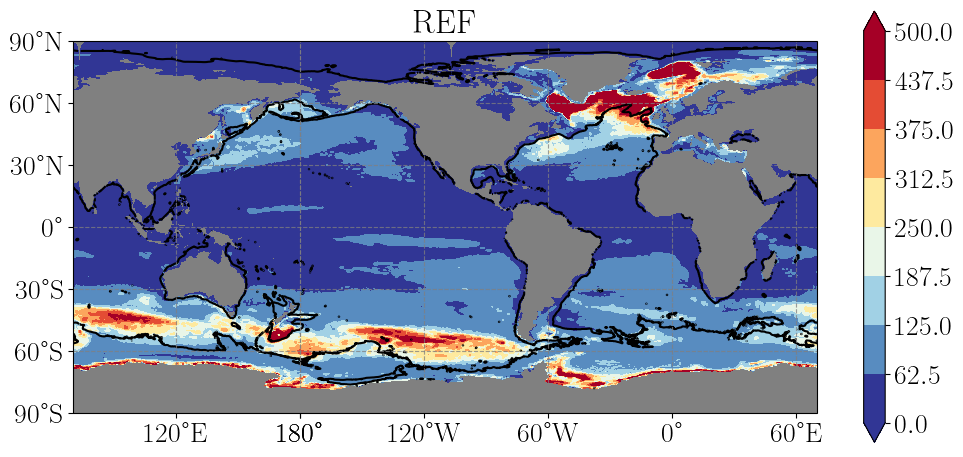

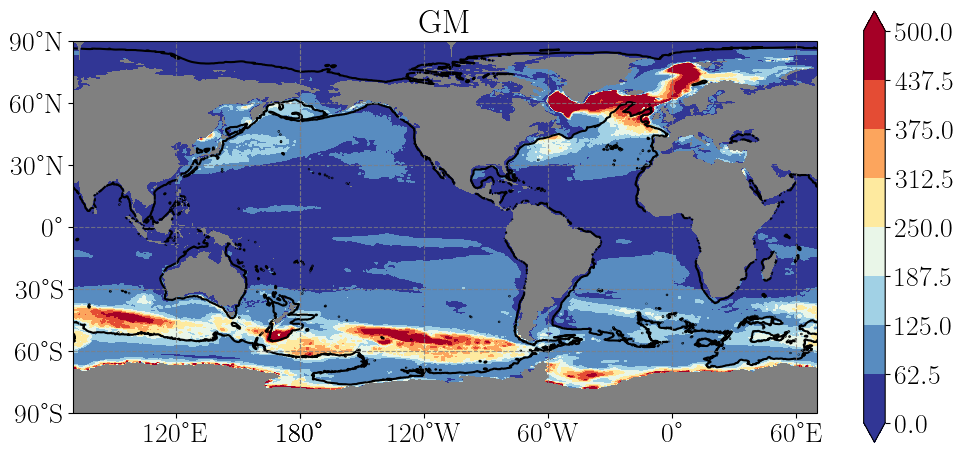

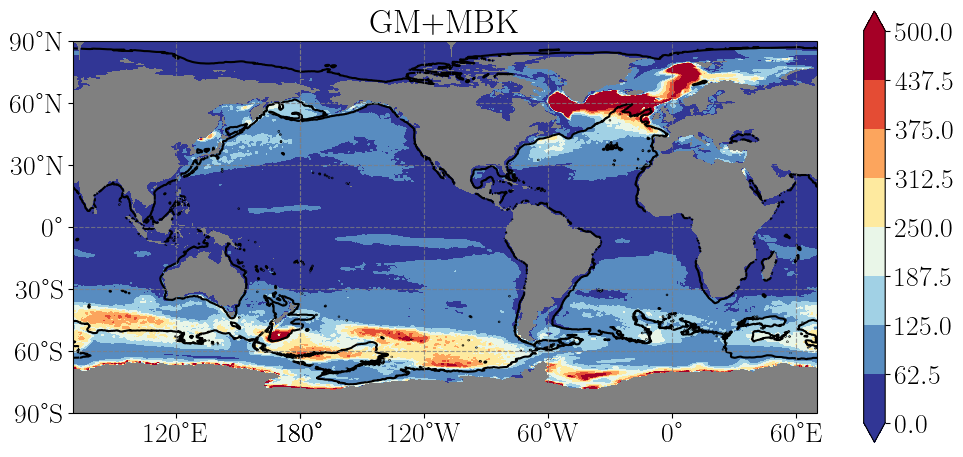

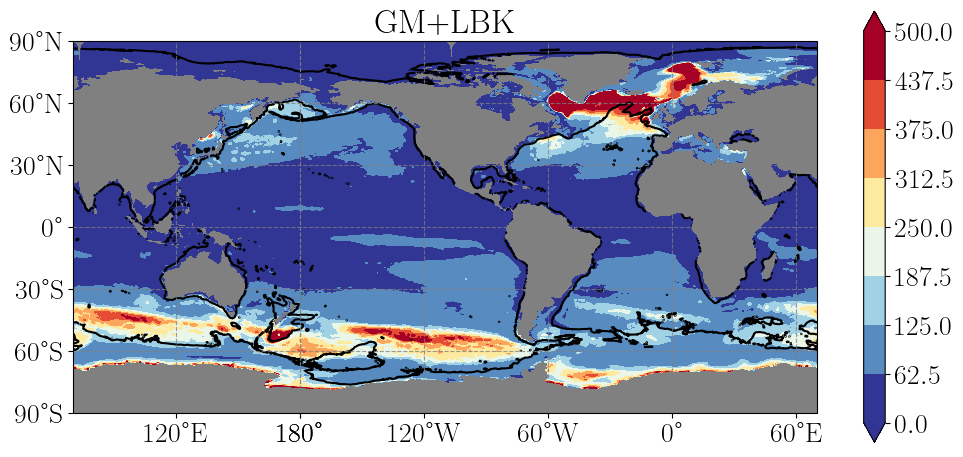

In [7]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = 0, 500
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R in zip(sims, res_funcs):
    title = sim.short_name
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(sim.ds.MLD_winter,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+"ML_"+title+'.png',dpi=300)

### Plot differences with reference simulation

In [14]:
diffs = []
for i in range(1,num_sims):
    diff = sims[i].ds.MLD_winter.fillna(0)-sims[0].ds.MLD_winter.fillna(0)
    diff = diff.assign_coords({'geolon': sims[0].grid['geolon'],
                       'geolat': sims[0].grid['geolat']})
    diff = diff.where(diff != 0, np.nan)

    diffs.append(diff)

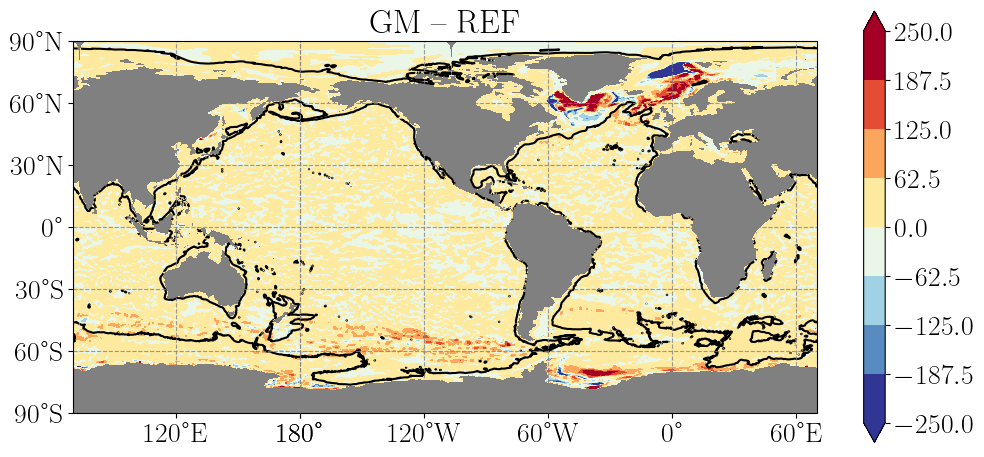

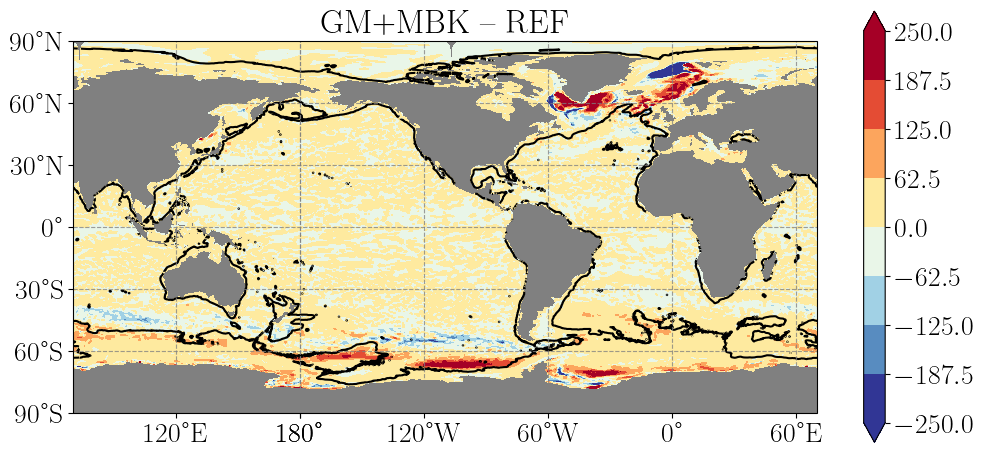

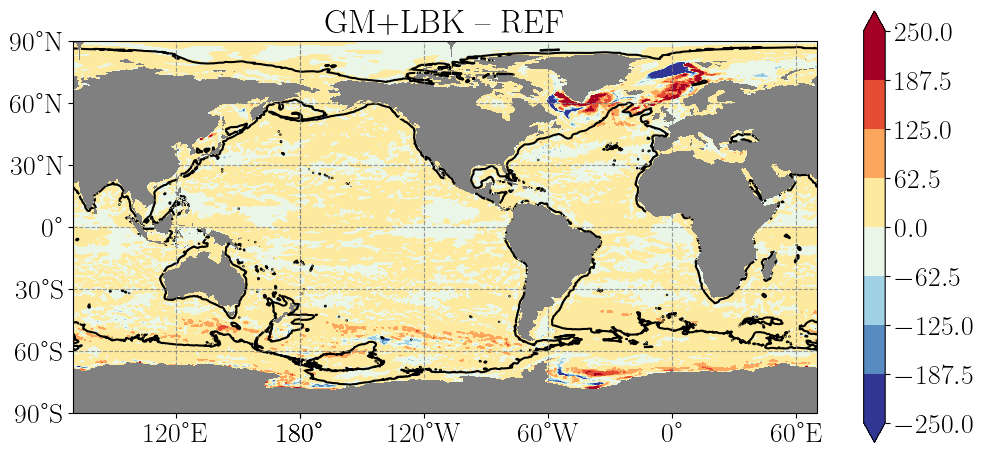

In [15]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -250, 250
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R, diff in zip(sims[1:], res_funcs[1:], diffs):
    title = sim.short_name + " – REF"
    mappable = sim.plot_global_discrete(diff,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+"ML_"+title+'.png',dpi=300)

### Plot differences with observations

In [16]:
deBoyer_path= '/glade/work/gmarques/cesm/tx1_4/mld/deBoyer2004/deBoyer04_MLD_remapped_to_tx1_4.nc'
mld_obs = xr.open_dataset(deBoyer_path)
mld_obs  = mld_obs.assign_coords({'geolon': sims[0].grid['geolon'], 'geolat': sims[0].grid['geolat']})

grid = xr.open_dataset(sims[0].grid_path)

In [17]:
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_JFM = np.ma.masked_where(grid.wet == 0, obs_JFM)

months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_JAS = np.ma.masked_where(grid.wet == 0, obs_JAS)


obs_winter = obs_JAS.copy()
# find point closest to eq. and select data
j = int(np.abs( grid.geolat[:,0] - 0. ).argmin())
obs_winter[j::,:] = obs_JFM[j::,:]

obs_winter_da = xr.DataArray(obs_winter, dims=['yh','xh'],
                           coords={'yh' : grid.yh, 'xh' : grid.xh}).rename('MLD_winter')

obs_winter_da  = obs_winter_da.assign_coords({'geolon': sims[0].grid['geolon'], 'geolat': sims[0].grid['geolat']})


In [18]:
%%time
diffs = []
for i in range(num_sims):
    diff = sims[i].ds.MLD_winter.fillna(0)-obs_winter_da.fillna(0)
    diff = diff.assign_coords({'geolon': sims[0].grid['geolon'],
                       'geolat': sims[0].grid['geolat']})
    diff = diff.where(diff != 0, np.nan)

    diffs.append(diff)

CPU times: user 118 ms, sys: 35.8 ms, total: 154 ms
Wall time: 181 ms


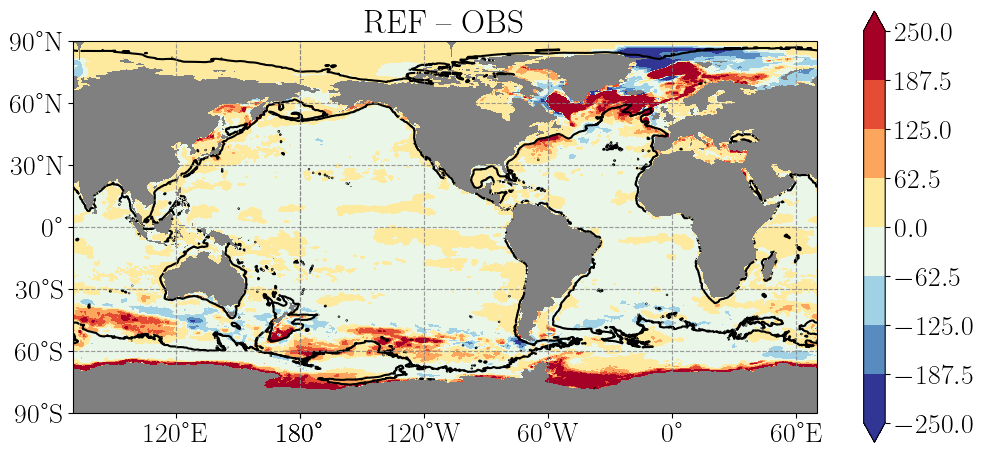

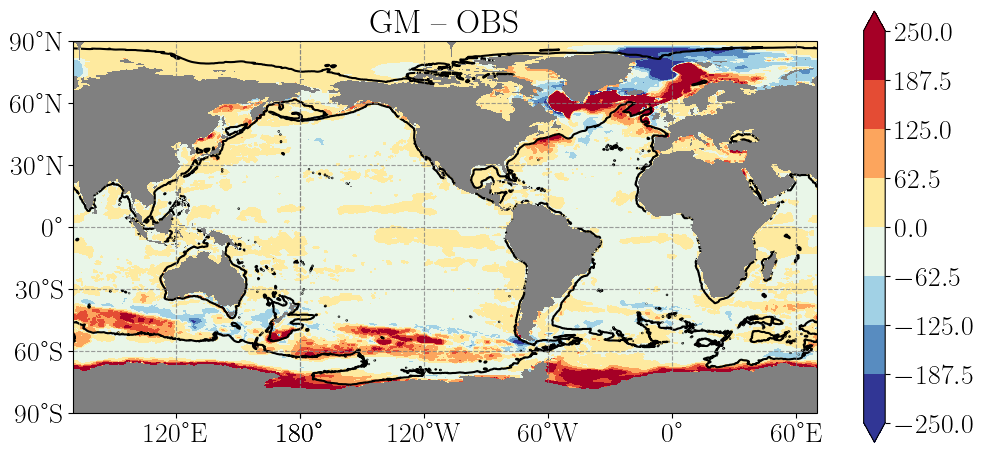

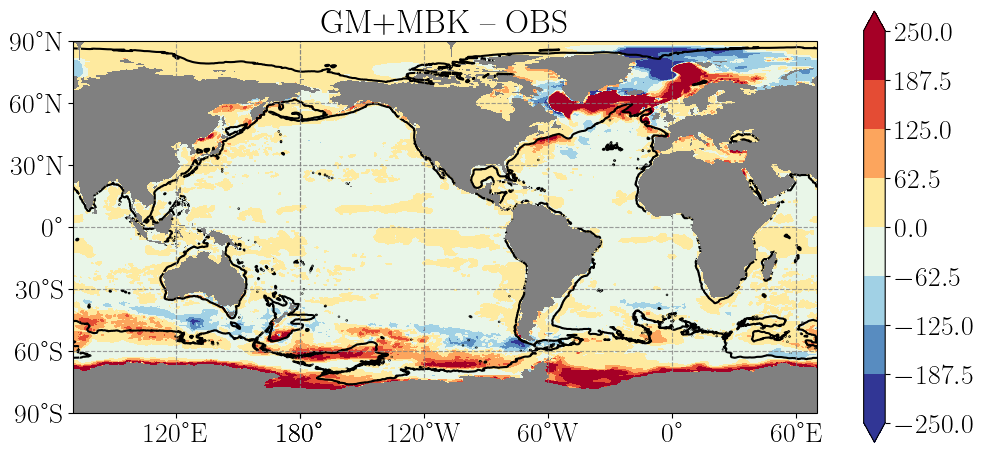

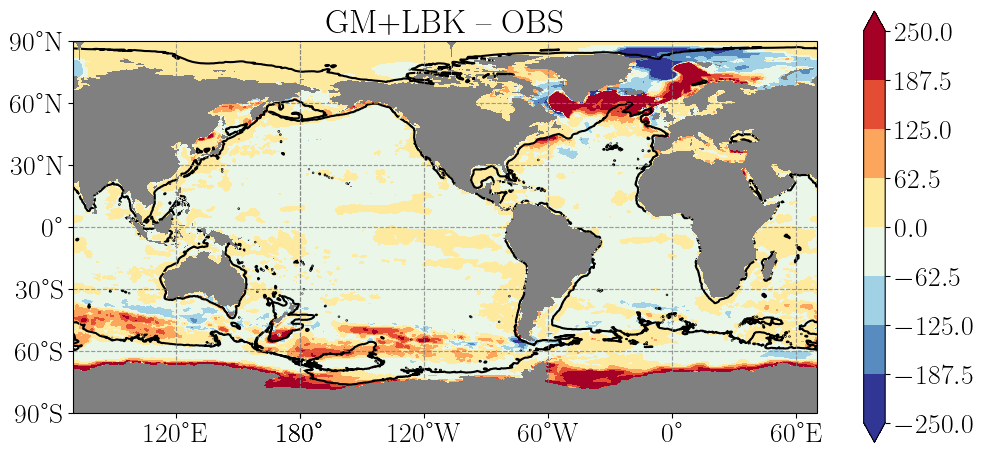

In [19]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -250, 250
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R, diff in zip(sims, res_funcs, diffs):
    title = sim.short_name + " – OBS"
    mappable = sim.plot_global_discrete(diff,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+"ML_"+title+'.png',dpi=300)